In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [62]:
def load_data(img_dir, valid_split_size):
    """
    Load training data and split it into training and validation set
    """
    data_df = pd.read_csv(os.path.join(img_dir, 'driving_log.csv'))

    #X = data_df[['center', 'left', 'right']].values
    X = data_df[['center']].values
    y = data_df['steering'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_split_size, random_state=0)

    return X_train, X_valid, y_train, y_valid


In [63]:
X_train, X_valid, y_train, y_valid = load_data('data', 0.2)
print(X_train.shape)
print(X_valid.shape)
print(X_train[0])

(6428, 1)
(1608, 1)
['IMG/center_2016_12_01_13_43_40_097.jpg']


In [66]:
def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


In [67]:
def show_images(img, img1, img2, img3, img4):
    plt.figure(figsize=(20, 8))
    plt.subplot(2, 4, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(2, 4, 2)
    plt.imshow(img1)
    plt.title("Cropped image")
    plt.subplot(2, 4, 3)
    plt.imshow(img2)
    plt.title("Brightness randomly adjusted image")
    plt.subplot(2, 4, 4)
    plt.imshow(img3)
    plt.title("Flipped original image")
    plt.subplot(2, 4, 5)
    plt.imshow(img4)
    plt.title("Flipped augmented brightness image")
    plt.show()

In [75]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    # Increase or decrease brightness by random
    random_bright = 1.0 - 0.5 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [80]:
def preprocess(img):
    cropped_img = img[50:140][:]
    blurred_img = cv2.GaussianBlur(cropped_img, (3,3), 0)
    #resize blurred image
    blurred_img = cv2.resize(blurred_img,(200, 66), interpolation = cv2.INTER_AREA)
    return blurred_img
   

In [83]:
def gen_data(img, steer_value):
    images = np.empty([3, 66,200,3])
    steer_values = np.empty([3])
    images[0] = augment_brightness_camera_images(img)
    images[1] = cv2.flip(img, 1)
    images[2] = cv2.flip(images[0], 1)
    steer_values[0] = steer_value
    steer_values[1] = -1 * steer_value
    steer_values[2] = -1 *steer_value
    return images, steer_values

In [87]:
def gen_all_cam_data(center, left, right, steer_value):
    images = np.empty([12, 66,200,3])
    steer_values = np.empty([12])
    images[0:2], steer_values[0:2] = gen_data(center, steer_value)
    images[3:5], steer_values[3:5] = gen_data(left, steer_value + 0.2)
    images[6:8], steer_values[6:8] = gen_data(right, steer_value - 0.2)
    #Add original data as well
    images[9], steer_values[9] = center, steer_value
    images[10], steer_values[10] = left, steer_value + 0.2
    images[11], steer_values[11] = right, steer_value - 0.2
    return images, steer_values
    

In [61]:
def build_model(input, keep_prob):
    """
    Nvidia Model from - https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=input))
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()

    return model

In [65]:
def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, 66,200,3])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            image_center = preprocess(load_image(data_dir, center)) 
            image_left = preprocess(load_image(data_dir, left))
            image_right = preproces(load_image(data_dir, right))
            # add the image and steering angle to the batch
            if is_training:
                images[i:i+11], steers[i:i+11] = gen_all_cam_data(image_center, image_left, image_right, steering_angle)
                i += 12
            else:
                images[i], steers[i] = image_center, steering_angle
                i += 1
            if i == batch_size:
                break
        yield images, steers

In [64]:
def train_model(model, img_dir, X_train, X_valid, y_train, y_valid):
    """
    Train the model
    """
    checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))
    batch_size = 120
    samples_per_epoch = 6428
    nb_epoch = 3
        
    model.fit_generator(batch_generator(img_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batch_generator(img_dir, X_valid, y_valid, batch_size, False),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)



(160, 320, 3)
0.0
(66, 200, 3)


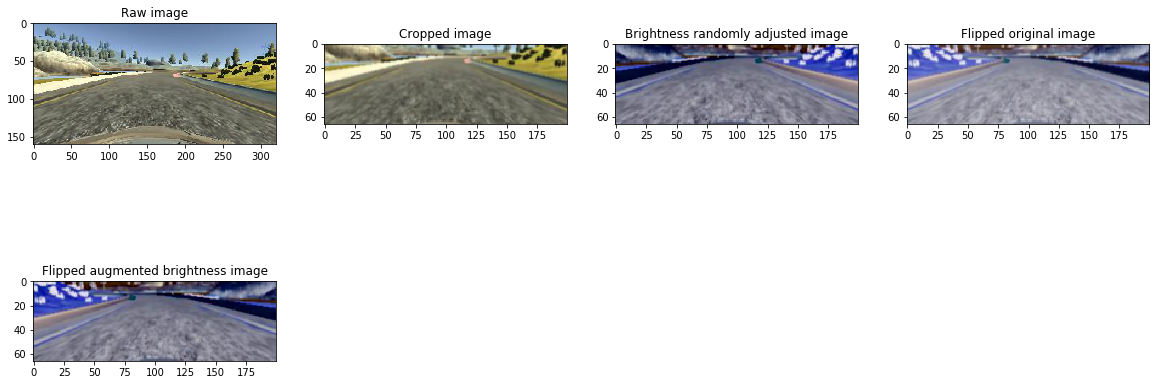

In [86]:
X_train, X_valid, y_train, y_valid = load_data('data', 0.2)
img_file =  X_train[0][0]
steer_value = y_train[0]
img =  mpimg.imread(os.path.join('data', img_file.strip()))
print(img.shape)
print(steer_value)

cropped_img = img[50:140][:]
blurred_img = cv2.GaussianBlur(cropped_img, (3,3), 0)
#resize blurred image
blurred_img = cv2.resize(blurred_img,(66, 200), interpolation = cv2.INTER_AREA)

aug_bright_img = augment_brightness_camera_images(blurred_img)

#Flip original in Vertical axis
flip_orig_img = cv2.flip(blurred_img, 1)

#Flip aug_bright image in Vertical axis
flip_aug_bright_img = cv2.flip(aug_bright_img, 1)


#show_images(img, blurred_img,aug_bright_img,flip_orig_img, flip_aug_bright_img)

processed_img =  preprocess(img)
print(processed_img.shape)
aug_images, steer_values = gen_data(processed_img, steer_value)
show_images(img, processed_img, aug_images[0], aug_images[1], aug_images[2])





In [ ]:
data = load_data('data', 0.2)
#img, sangle = batch_generator('data', data[0], data[2], 40, True)
#print(sangle)

model = build_model((66,200,3), 0.5)
train_model(model, 'data', *data)